In [1]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import train_test_dataloader_split, FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
!nvidia-smi
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
dataset = load_serialized_dataset('CircularHornDataset1_Train')

train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.7)

train_params, train_fields = next(iter(train_dataloader))
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))



In [22]:
length_scale_sweep = np.linspace(0.1,4,20)

train_loss = []
val_loss = []

for length_scale in length_scale_sweep:
    kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best Val:0.007998921533198125, at length scale:[1.12631579]


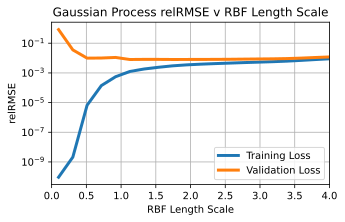

In [26]:
plt.figure(figsize = (5,3))
plt.plot(length_scale_sweep,train_loss,label = 'Training Loss',linewidth = 3)
plt.plot(length_scale_sweep,val_loss,label = 'Validation Loss',linewidth = 3)
#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,max(length_scale_sweep)])
plt.grid()
plt.title('Gaussian Process relRMSE v RBF Length Scale')
plt.xlabel('RBF Length Scale')
plt.ylabel('relRMSE')

plt.legend()
best_val = length_scale_sweep[val_loss == min(val_loss)]
print(f'Best Val:{min(val_loss)}, at length scale:{best_val}')
figSaver.save(filename = 'RBF_Length_scale_error')

array([1.])

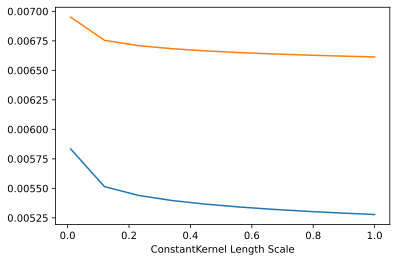

In [5]:
ConstVals = np.linspace(0.01,1,10)


train_loss = []
val_loss = []

for ConstVal in ConstVals:
    kernel = ConstantKernel(ConstVal, constant_value_bounds="fixed") * RBF(2.10224719, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))

plt.figure()
plt.plot(ConstVals,train_loss,label = 'Training Loss')
plt.plot(ConstVals,val_loss,label = 'Validation Loss')
plt.xlabel('ConstantKernel Length Scale')
ConstVals[val_loss == min(val_loss)]

In [6]:
from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
const_scales = np.logspace(0.01, 1.1, num=dims[0], base=10)-1
RBF_scales = np.logspace(0.01,  1.1, num=dims[1], base=10)-1
const_scales, RBF_scales = np.meshgrid(const_scales, RBF_scales)


score_grid = np.array([])

for const_scale,RBF_scale in zip(const_scales.flatten(),RBF_scales.flatten()):

    
    kernel = ConstantKernel(const_scale, constant_value_bounds="fixed") * RBF(RBF_scale,length_scale_bounds="fixed")
    gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

Const:0.0232929922807541, Length Scale: 0.0232929922807541, Score: 0.8952613673559301
Const:0.35241852546266106, Length Scale: 0.0232929922807541, Score: 0.8952613636249579
Const:0.787401928687085, Length Scale: 0.0232929922807541, Score: 0.89526136347909
Const:1.3622906626344617, Length Scale: 0.0232929922807541, Score: 0.8952613634292165
Const:2.1220829994678336, Length Scale: 0.0232929922807541, Score: 0.8952613634047604
Const:3.126250173082264, Length Scale: 0.0232929922807541, Score: 0.8952613633906743
Const:4.453391371646277, Length Scale: 0.0232929922807541, Score: 0.8952613633818058
Const:6.207385932717452, Length Scale: 0.0232929922807541, Score: 0.8952613633758998
Const:8.52552429176778, Length Scale: 0.0232929922807541, Score: 0.8952613633718248
Const:11.589254117941675, Length Scale: 0.0232929922807541, Score: 0.8952613633689388
Const:0.0232929922807541, Length Scale: 0.35241852546266106, Score: 0.008578085189941569
Const:0.35241852546266106, Length Scale: 0.352418525462661

0.5081955558549525


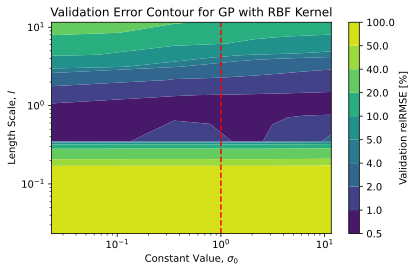

<Figure size 432x288 with 0 Axes>

In [7]:
from matplotlib import ticker, cm
from ssapp.Utils import FigureSaver



fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(const_scales,RBF_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2,4]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='r',linestyle = '--')
ax.set_xlabel("Constant Value, $\sigma_0$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with RBF Kernel")
plt.tight_layout()
plt.show()
figSaver.save(filename = 'ValidationErrorContourPlot_RBF')

In [8]:

from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
length_scales = np.logspace(0.1, 1.5, num=dims[0], base=10)-1
Nu_scales = np.logspace(0.1,  1.5, num=dims[1], base=10)-1
length_scales, Nu_scales = np.meshgrid(length_scales, Nu_scales)


score_grid = np.array([])

for length_scale,Nu_scale in zip(length_scales.flatten(),Nu_scales.flatten()):

    
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=length_scale,length_scale_bounds='fixed',nu=Nu_scale)

    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Length Scale:{length_scale}, Nu: {Nu_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

Length Scale:0.2589254117941673, Nu: 0.2589254117941673, Score: 0.24095351660618664
Length Scale:0.801173528334133, Nu: 0.2589254117941673, Score: 0.09983842047017144
Length Scale:1.576980374514878, Nu: 0.2589254117941673, Score: 0.08730054780156297
Length Scale:2.686945064519575, Nu: 0.2589254117941673, Score: 0.0842883373339761
Length Scale:4.274997063702618, Nu: 0.2589254117941673, Score: 0.0832564545604722
Length Scale:6.547059566968904, Nu: 0.2589254117941673, Score: 0.08282824560803646
Length Scale:9.7977516232771, Nu: 0.2589254117941673, Score: 0.08262558153863411
Length Scale:14.448591479026764, Nu: 0.2589254117941673, Score: 0.08251894987326158
Length Scale:21.10265497970638, Nu: 0.2589254117941673, Score: 0.08245740797398032
Length Scale:30.622776601683793, Nu: 0.2589254117941673, Score: 0.08241887747521319
Length Scale:0.2589254117941673, Nu: 0.801173528334133, Score: 0.16315188927758625
Length Scale:0.801173528334133, Nu: 0.801173528334133, Score: 0.03080045344936632
Length

In [9]:
print(score_grid.shape)

(10, 10)


0.5052650585067382


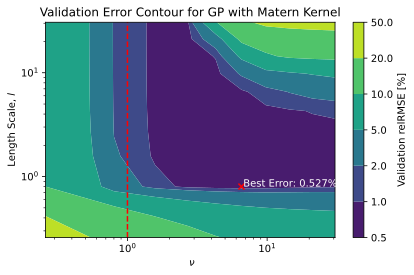

In [10]:

fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(Nu_scales,length_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='r',linestyle = '--')
ax.set_xlabel(r" $ \nu$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with Matern Kernel")

figSaver.save(filename = 'ValidationErrorContourPlot_Matern')



ind = np.unravel_index(np.argmin(score_grid, axis=None), score_grid.shape)

best_length_scale = length_scales[ind]
best_Nu_scales = Nu_scales[ind]
ax.scatter(best_Nu_scales,best_length_scale,marker = 'x',c='r')
ax.annotate(f'Best Error: {100*score_grid[ind]:.3f}%', (best_Nu_scales+0.2,best_length_scale),c='w')
plt.tight_layout()
plt.show()

In [13]:
kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=best_length_scale,length_scale_bounds='fixed',nu=best_Nu_scales)

gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
iter_score = score(gp,val_params,val_fields)
score_grid = np.append(score_grid,iter_score)
print(f'Length Scale:{best_length_scale}, Nu: {best_Nu_scales}, Score: {iter_score}')

Length Scale:0.801173528334133, Nu: 6.547059566968904, Score: 0.005265058506738227


In [18]:
dims = (5,5)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
length_scales = np.linspace(0.4, 1.5, num=dims[0])
Nu_scales = np.linspace(5,  10, num=dims[1])
length_scales, Nu_scales = np.meshgrid(length_scales, Nu_scales)


score_grid = np.array([])

for length_scale,Nu_scale in zip(length_scales.flatten(),Nu_scales.flatten()):

    
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=length_scale,length_scale_bounds='fixed',nu=Nu_scale)

    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Length Scale:{length_scale}, Nu: {Nu_scale}, Score: {iter_score}')


score_grid = score_grid.reshape(dims)


Length Scale:0.4, Nu: 5.0, Score: 0.02420740202605264
Length Scale:0.675, Nu: 5.0, Score: 0.005968193340884413
Length Scale:0.9500000000000001, Nu: 5.0, Score: 0.00525102861210831
Length Scale:1.225, Nu: 5.0, Score: 0.00539056091921626
Length Scale:1.5, Nu: 5.0, Score: 0.005580628587776047
Length Scale:0.4, Nu: 6.25, Score: 0.021535441567877307
Length Scale:0.675, Nu: 6.25, Score: 0.00551849959059935
Length Scale:0.9500000000000001, Nu: 6.25, Score: 0.005353910505014742
Length Scale:1.225, Nu: 6.25, Score: 0.005715586388645733
Length Scale:1.5, Nu: 6.25, Score: 0.006157025972756339
Length Scale:0.4, Nu: 7.5, Score: 0.019641230445830448
Length Scale:0.675, Nu: 7.5, Score: 0.005349195652723625
Length Scale:0.9500000000000001, Nu: 7.5, Score: 0.005554815513154832
Length Scale:1.225, Nu: 7.5, Score: 0.0062500047376636975
Length Scale:1.5, Nu: 7.5, Score: 0.006768648812818761
Length Scale:0.4, Nu: 8.75, Score: 0.018217838608001503
Length Scale:0.675, Nu: 8.75, Score: 0.005311323759515582
Le

0.5052510286121084


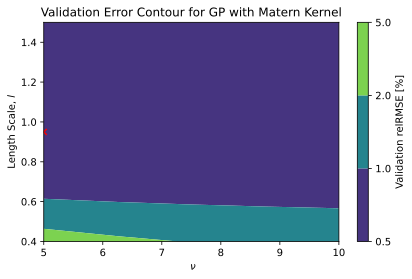

In [21]:
fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(Nu_scales,length_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')

ax.set_xlabel(r" $ \nu$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with Matern Kernel")

figSaver.save(filename = 'ValidationErrorContourPlot_Matern')



ind = np.unravel_index(np.argmin(score_grid, axis=None), score_grid.shape)

best_length_scale = length_scales[ind]
best_Nu_scales = Nu_scales[ind]
ax.scatter(best_Nu_scales,best_length_scale,marker = 'x',c='r')

plt.tight_layout()
plt.show()

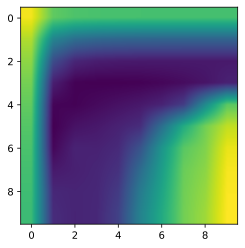

In [11]:
plt.figure()
plt.imshow(10*np.log10(score_grid),interpolation='bilinear')